In [1]:
import os
import sys
base_dir = os.getcwd()
# base_dir = os.path.dirname(current_dir)

# sys.path.append(base_dir)

In [2]:
import pandas as pd
import os
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
import sklearn.metrics as metrics
from utilities import featurization as fzn
from model import tecrf
import joblib

# The directory contains the dataset that has been divided into train, val, and test data with a 5 fold cross validation scheme
data_url = os.path.join(base_dir, 'data/preprocessed_dataset/5fold_cv')

C:\Users\A1\miniconda3\envs\nbl\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Model Evaluation

In [3]:
def reader_dataset(url):
    list_folder = listdir(url)
    list_df = []
    for f in list_folder:
        df_train = pd.read_csv(url+'/'+f+'/train.csv')
        df_val = pd.read_csv(url+'/'+f+'/val.csv')
        df_test = pd.read_csv(url+'/'+f+'/test.csv')
        list_df.append([df_train, df_val, df_test])
    return list_df

def confusion_matrix_calc(actual_, predict_, boundary):
    assert len(actual_)==len(predict_)
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for n in range(len(actual_)):
        if actual_[n]>=boundary and predict_[n]>=boundary:
            TP+=1
        elif actual_[n]<boundary and predict_[n]<boundary:
            TN+=1
        elif actual_[n]>=boundary and predict_[n]<boundary:
            FN+=1
        elif actual_[n]<boundary and predict_[n]>=boundary:
            FP+=1
    return TP, TN, FP, FN

def model_test(train, test, model):
    X_train, y_train, formulae_train = fzn.apply_scheme(train['formula'], list(train['target']))
    X_test, y_test, formulae_test = fzn.apply_scheme(test['formula'], list(test['target']))
    
    scalar = MinMaxScaler()
    X_train_scaled = scalar.fit_transform(X_train)
    X_test_scaled = scalar.transform(X_test)
    print
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    return y_test, y_pred, formulae_test

In [13]:
mae_list = []
pred_list = []
y_list = []
formula_list = []
recall_list = []
precision_list = []
f1_list = []
rmse_list = []
r2_list = []
error_list = []

data_kfold = reader_dataset(data_url) #read data

for d in range(len(data_kfold)):
    train = data_kfold[d][0]
    val = data_kfold[d][1]
    test = data_kfold[d][2]
    
#     model = RandomForestRegressor(random_state = 1, n_estimators= 300, min_samples_split= 5, min_samples_leaf= 2, max_features= 'sqrt', max_depth= 50, bootstrap= False)
#     model = XGBRegressor(random_state = 0, n_estimators= 300, max_depth=7, learning_rate=0.1, colsample_bytree=0.6)
    
#     y_test, y_pred, formulae_test = model_test(train, test, model)
    params = {
                    'rf1':[None, 150],
                    'rf2':[0.3, 150],
#                     'rf3':[0.2, 100],

                }
    model = tecrf.TECRF(parameters=params)
    model.train(train, val)
    y_pred = model.predict(test)
    y_test = test['target']
    formulae_test = test['formula']
    
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

    mae_list.append(mae)
    r2_list.append(r2)
    rmse_list.append(rmse)
    pred_list.append(list(y_pred))
    error_list.append([y_act-ypred for y_act, ypred in zip(y_test, y_pred)])
    y_list.append(list(y_test))
    formula_list.append(list(formulae_test))

    TP, TN, FP, FN = confusion_matrix_calc(y_test, y_pred, -4)
    print('TP={}, TN={}, FP={}, FN={}'.format(TP, TN, FP, FN))
    rec_ = TP/(TP+FN)
    pre_ = TP/(TP+FP)
    f1_score = 2 * (pre_ * rec_) / (pre_ + rec_)
    recall_list.append(rec_)
    precision_list.append(pre_)
    f1_list.append(f1_score)
    
    print('Fold {} - MAE: {} - RMSE: {} - F1: {}'.format(d+1, mae, rmse, f1_score))
    
print('Avg MAE: {} - Avg Recall: {} - Avg Precision: {} - Avg F1: {}'.format(sum(mae_list)/len(mae_list), sum(recall_list)/len(recall_list), sum(precision_list)/len(precision_list), sum(f1_list)/len(f1_list)))
print('Avg R2: {} - Avg RMSE: {}'.format(sum(r2_list)/len(r2_list), sum(rmse_list)/len(rmse_list)))

(203, 300)
300
TP=89, TN=88, FP=12, FN=14
Fold 1 - MAE: 0.538271508136359 - RMSE: 0.8875461785911979 - F1: 0.8725490196078431
(203, 300)
300
TP=92, TN=86, FP=14, FN=11
Fold 2 - MAE: 0.5216157463059629 - RMSE: 0.8939847545424597 - F1: 0.8803827751196173
(203, 300)
300
TP=87, TN=86, FP=14, FN=16
Fold 3 - MAE: 0.5249393336296674 - RMSE: 0.8807859970578052 - F1: 0.8529411764705882
(203, 300)
300
TP=89, TN=86, FP=14, FN=14
Fold 4 - MAE: 0.5512844362699056 - RMSE: 0.8963446421217607 - F1: 0.8640776699029126
(203, 300)
300
TP=92, TN=88, FP=12, FN=11
Fold 5 - MAE: 0.5315203482080151 - RMSE: 0.8966167064027354 - F1: 0.8888888888888888
Avg MAE: 0.533526274509982 - Avg Recall: 0.8718446601941748 - Avg Precision: 0.8718383680491855 - Avg F1: 0.8717679059979702
Avg R2: 0.6598700320261035 - Avg RMSE: 0.8910556557431917


## Training


In [53]:
train = pd.read_csv(data_url+'/1/train.csv')
val = pd.read_csv(data_url+'/1/val.csv')
test = pd.read_csv(data_url+'/1/test.csv')
trainnval = pd.concat([train, val]).reset_index()

model = tecrf.TECRF()
model.train(trainnval, test)

model_url = os.path.join(base_dir, 'model.joblib')
joblib.dump(model, model_url)

['D:\\GITHUB\\ML_SSE\\model.joblib']

## Predict new data

In [64]:
data_substitution = pd.read_csv(os.path.join(base_dir, 'element_substitution/new_formula.csv'))
dummy_target = [0]*len(new_data)

data_substitution = pd.DataFrame({'formula':list(data_substitution['new_formula']), 'target':dummy_target})

In [65]:
model= joblib.load(model_url)

prediction = model.predict(data_substitution)
df_predict = pd.DataFrame({'formula': data_substitution['formula'], 'prediction':prediction})
df_predict

(18262, 750)
750


,formula,prediction
0,Li4.2Si0.8Ga0.2S4,-6.140656
1,Li4.2Si0.8Fe0.2S4,-5.622127
2,Li4.2Si0.8Cr0.2S4,-5.580930
3,Li4.2Si0.8In0.2S4,-5.485577
4,Li4.2Si0.8Co0.2S4,-5.649385
...,...,...
18257,Li7Ho3Sn2O12,-6.246554
18258,Li7Ho3Tb2O12,-7.687574
18259,Li7Ho3Mo2O12,-7.250024
18260,Li7Ho3Pb2O12,-6.133337


<AxesSubplot:>

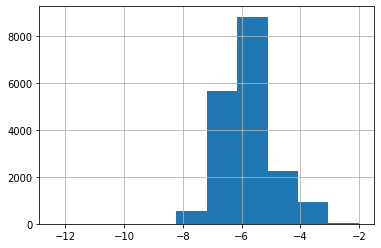

In [66]:
df_predict['prediction'].hist()

In [69]:
df_predict.to_csv(os.path.join(base_dir, 'new_formula_prediction.csv'))